<a href="https://colab.research.google.com/github/ML-HW-SYS/a4-anya-23-ct/blob/main/1_numerical_precision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Numerical Precision

In this section, you will investigate how different convolution
and matrix-matrix multiplication kernel performs when changing the
numerical precision.

## 1. Set-up

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Make sure your token is stored in a txt file at the location below.
# This way there is no risk that you will push it to your repo
# Never share your token with anyone, it is basically your github password!
with open('/content/gdrive/MyDrive/ece5545/token.txt') as f:
    token = f.readline().strip()
# Use another file to store your github username
with open('/content/gdrive/MyDrive/ece5545/git_username.txt') as f:
    handle = f.readline().strip()

In [3]:
# Clone your github repo
YOUR_TOKEN = token
YOUR_HANDLE = handle
BRANCH = "main"

# %mkdir /content/gdrive/MyDrive/ece5545
%cd /content/gdrive/MyDrive/ece5545
# !git clone https://{YOUR_TOKEN}@github.com/ML-HW-SYS/a4-{YOUR_HANDLE}.git
%cd /content/gdrive/MyDrive/ece5545/a4-{YOUR_HANDLE}
!git checkout {BRANCH}
!git pull
%cd /content/gdrive/MyDrive/ece5545

PROJECT_ROOT = f"/content/gdrive/MyDrive/ece5545/a4-{YOUR_HANDLE}"

/content/gdrive/MyDrive/ece5545
/content/gdrive/MyDrive/ece5545/a4-anya-23-ct
M	1-numerical_precision.ipynb
M	2-svd_rank.ipynb
M	fix_workflow.diff
Already on 'main'
Your branch is up to date with 'origin/main'.
Already up to date.
/content/gdrive/MyDrive/ece5545


In [4]:
# This extension reloads all imports before running each cell
%load_ext autoreload
%autoreload 2

Verify the following cell prints your github repository.

In [5]:
!ls {PROJECT_ROOT}

 1-numerical_precision.ipynb
 2-svd_rank.ipynb
'a Batch of MNIST Digits.png'
'a Random Matrix.png'
 compression_ratio_vs_acc_and_runtime.png
 compression_ratio_vs_acc.png
 compression_ratio_vs_runtime.png
 data
 errors_plot.png
 fft_reconstruction_error.png
 fix_workflow.diff
'Intermediate activation of a Fully connected network.png'
 logmatmul_reconstruction_error.png
 low_rank_data.pickle
 mnist.py
'Pixels of Cat Image.png'
 README.md
 src
 tests
'Weight matrix of a fully connected neural network.png'
 winograd_reconstruction_loss.png


In [6]:
!pip install torch numpy matplotlib

# 2. Convolution

In the following cell(s), please plot the reconstruction error of an
approximated tensor (in the y-axis) with the numerical precision
(in the x-axis). Please show one plot for `winograd` and one plot for `fft`.

In [7]:
%cd {PROJECT_ROOT}

/content/gdrive/MyDrive/ece5545/a4-anya-23-ct


In [8]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [9]:
from src.conv2d import winograd, pytorch, fft
from src.matmul import logmatmul

In [20]:
# device = 'cuda'
device = 'cpu'
precisions = [torch.float64, torch.float32, torch.float16, torch.int64, torch.int32, torch.int16, torch.int8]
precisions_str = ['float64', 'float32', 'float16', 'int64', 'int32', 'int16', 'int8']

precisions2 = [torch.float64, torch.float32, torch.int64, torch.int32, torch.int16, torch.int8]
precisions_str2 = ['float64', 'float32', 'int64', 'int32', 'int16', 'int8']

float_types = [torch.float64, torch.float32, torch.float16]

In [11]:
def reconstruction_error(reference, prediction):
    reference = reference.astype(float)
    prediction = prediction.astype(float)
    return np.mean((reference - prediction)**2)

In [23]:
def compute_winograd_errors(precisions, device):
    errors = []
    for precision in precisions:
        if precision in float_types:
            input_tensor = torch.rand(size=(43,43), dtype=precision, device=device)
            kernel = torch.rand(size=(3,3), dtype=precision, device=device)
            bias = torch.tensor([0.1], dtype=precision, device=device)
        else:
            input_tensor = torch.randint(low=-3, high=3, size=(43, 43), dtype=precision, device=device)
            kernel = torch.randint(low=-3, high=3, size=(3, 3), dtype=precision, device=device)
            bias = torch.tensor([0], dtype=precision, device=device)

        winograd_output = winograd(input_tensor, kernel, bias).cpu().numpy()
        pytorch_output = pytorch(input_tensor, kernel, bias).cpu().numpy()
        error = reconstruction_error(pytorch_output, winograd_output)
        errors.append(error)
        torch.cuda.empty_cache()
    return errors

In [39]:
def compute_fft_errors(precisions, device):
    errors = []
    for precision in precisions:
        if precision in float_types:
            input_tensor = torch.rand(size=(31,31), dtype=precision, device=device)
            kernel = torch.rand(size=(2,2), dtype=precision, device=device)
            bias = torch.tensor([0.1], dtype=precision, device=device)
        else:
            input_tensor = torch.randint(low=-3, high=3, size=(31,31), dtype=precision, device=device)
            kernel = torch.randint(low=-3, high=3, size=(2,2), dtype=precision, device=device)
            bias = torch.tensor([0], dtype=precision, device=device)

        fft_output = fft(input_tensor, kernel, bias).cpu().numpy()
        pytorch_output = pytorch(input_tensor, kernel, bias).cpu().numpy()
        error = reconstruction_error(pytorch_output, fft_output)
        errors.append(error)
        torch.cuda.empty_cache()
    return errors

In [45]:
def compute_logmatmul_errors(precisions, device):
    errors = []
    for precision in precisions:
        if precision in float_types:
            A = torch.rand(size=(100,80), dtype=precision, device=device)
            B = torch.rand(size=(80,100), dtype=precision, device=device)
        else:
            A = torch.randint(low=-3, high=3, size=(100,80), dtype=precision, device=device)
            B = torch.randint(low=-3, high=3, size=(80,100), dtype=precision, device=device)
        naive_result = (A.matmul(B)).cpu().numpy()
        logmatmul_result = logmatmul(A, B).cpu().numpy()
        error = reconstruction_error(naive_result, logmatmul_result)
        errors.append(error)
        torch.cuda.empty_cache()
    return errors

In [47]:
def plot_errors(errors, precisions_str, title, save_filename):
    plt.figure()
    plt.title(title)
    plt.plot(precisions_str, errors, 'b')
    plt.xlabel('Precisions')
    plt.ylabel('Reconstruction Error')
    plt.yscale('log')  # Set y-axis scale to logarithmic
    plt.savefig(save_filename)
    plt.show()

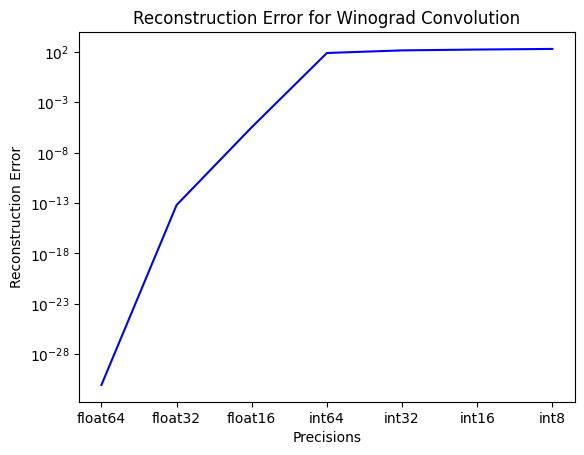

In [48]:
# from src.conv2d import winograd
# TODO: plot the error v.s. precision curve
winograd_errors = compute_winograd_errors(precisions, device)
plot_errors(winograd_errors, precisions_str, 'Reconstruction Error for Winograd Convolution', 'winograd_reconstruction_loss.png')

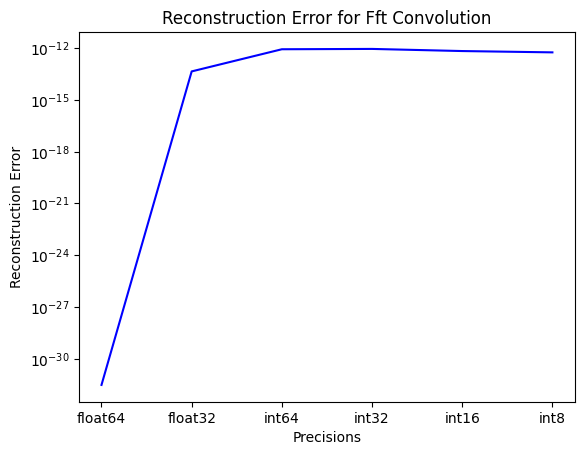

In [49]:
# from src.conv2d import fft
# TODO: plot the error v.s. precision curve

# errors_fft = compute_fft_errors(precisions, device)
# plot_errors(errors_fft, precisions_str, 'Reconstruction Error for Fft Convolution','fft_reconstruction_error.png')

errors_fft = compute_fft_errors(precisions2, device)
plot_errors(errors_fft, precisions_str2, 'Reconstruction Error for Fft Convolution','fft_reconstruction_error.png')

# 3. Matrix-matrix Multiply

In the following cell(s), please plot the reconstruction error (in the y-axis)
with the different numerical precisions (in the x-axis) for `log` (i.e.
logorithmic matrix-matrix multiplication).

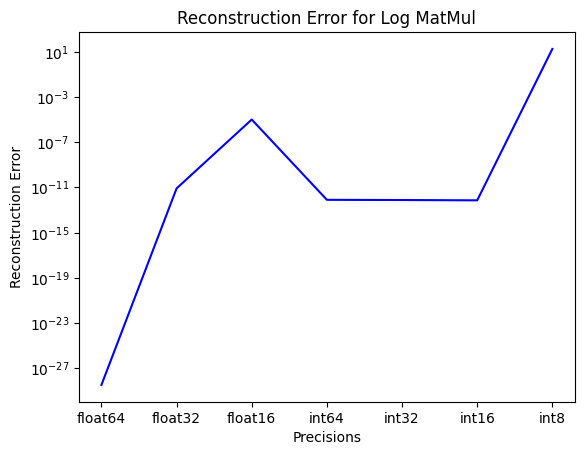

In [50]:
from src.matmul import logmatmul

# TODO: plot the error v.s. precision curve

logmatmul_errors = compute_logmatmul_errors(precisions, device)
plot_errors(logmatmul_errors, precisions_str, 'Reconstruction Error for Log MatMul','logmatmul_reconstruction_error.png')